<div align="center">
<font size="6" font-weight="bold">上海出租车出行模式与收入统计</font>
</div>
<center>APan 2025-01-02 </center>
<hr>

In [1]:
import ast
import datetime
import json
import os
import random
import re
import struct
import sys
import warnings
from pathlib import Path

import branca.colormap as cm
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from folium import Map
from folium.plugins import HeatMap
from shapely.geometry import Point
from tqdm import tqdm

# Set seed for reproducibility
np.random.seed(seed=1234)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 12

In [5]:
# 设置运行环境
BASE_DIR = Path.cwd().parent
DATA_DIR = Path(BASE_DIR, "data")
RESULT_DIR = Path(BASE_DIR, "results")
sys.path.append(str(Path(BASE_DIR, "src")))

import data_analysis

# 前期准备

## 提取 log 文件

In [6]:
def parse_trajectory_from_log_file(vehicle_log_fp, vehicle_id):
    track_points = []

    with open(vehicle_log_fp, "rb") as f:
        data = f.read()

    for i in range(0, len(data), 33):  # 每33个字节一个轨迹点信息
        if i + 33 <= len(data):
            point_data = data[i : i + 31]
            longitude = struct.unpack("!f", point_data[1:5])[0]  # 纬度信息
            latitude = struct.unpack("!f", point_data[5:9])[0]  # 经度信息
            timestamp = struct.unpack("!I", point_data[9:13])[0]  # 时间戳信息
            status = point_data[13]  # 车辆状态信息

            # 计算相对当天 0 点的秒数
            day_start = datetime.datetime.fromtimestamp(timestamp).replace(
                hour=0, minute=0, second=0, microsecond=0
            )
            seconds = (datetime.datetime.fromtimestamp(timestamp) - day_start).seconds

            track_points.append(
                {
                    "id": vehicle_id,
                    "longitude": longitude,
                    "latitude": latitude,
                    "time": seconds,
                    "status": status,
                }
            )

    return track_points

In [7]:
def capture_all_tracks_oneday(date_dir, vehicle_id_dic):
    all_tracks = []
    vehicle_counter = len(vehicle_id_dic)

    # 遍历每小时文件夹
    for hour in tqdm(range(24)):
        hour_dir = Path(date_dir, f"{hour}")

        if not hour_dir.exists():
            continue

        for vehicle_log_fp in hour_dir.rglob("*.log"):
            vehicle_plate = vehicle_log_fp.name[:-4]

            # 分配车辆 ID，创建对应字典
            if vehicle_plate not in vehicle_id_dic:
                vehicle_id_dic[vehicle_plate] = vehicle_counter
                vehicle_counter = len(vehicle_id_dic)
            vehicle_id = vehicle_id_dic[vehicle_plate]

            # 从单个车辆的 log 文件中提取信息
            track_points = parse_trajectory_from_log_file(vehicle_log_fp, vehicle_id)

            all_tracks.extend(track_points)

    # 整理成 df
    df_tracks = pd.DataFrame(all_tracks)
    df_tracks = df_tracks.sort_values(by=["id", "time"])
    df_tracks["date"] = int(date_dir.name)

    return df_tracks, vehicle_id_dic

# 提取订单信息

## 提取车辆轨迹数据

In [6]:
# 所有日期
date_list = [
    "20241101",
    # "20241102",
    # "20241103",
    # "20241104",
    # "20241105",
    # "20241106",
    # "20241107",
    # "20241108",
    # "20241109",
    # "20241110",
]

In [ ]:
vehicle_id_dic = {}
dfs_tracks_list = []

for date in date_list:
    print(f"=== {date} ===")
    date_dir = Path(DATA_DIR, date)

    # 提取某一天所有车辆的轨迹数据和车牌号
    df_tracks_oneday, vehicle_id_dic = capture_all_tracks_oneday(
        date_dir, vehicle_id_dic
    )

    # 保存车辆的轨迹数据
    dfs_tracks_list.append(df_tracks_oneday)

df_tracks = pd.concat(dfs_tracks_list, ignore_index=True)  # 合并

## 提取订单属性

In [12]:
DA = data_analysis.DA()

In [ ]:
# 数据清洗，排除异常（地理范围、status）
df = DA.clean_data(df_tracks)

# 提取订单数据
df_result_orders = DA.analyze_all_orders()

In [ ]:
# 保存实验结果
save_fp = Path(RESULT_DIR, "orders.xlsx")
df_result_orders.to_excel(save_fp, index=False)

## 加载订单数据

In [6]:
df_list = []
for i in tqdm(range(1, 6)):
    save_fp = Path(RESULT_DIR, f"orders{i}.xlsx")
    df_result = pd.read_excel(save_fp)
    df_list.append(df_result)

df_result_orders = pd.concat(df_list, ignore_index=True)

100%|██████████| 5/5 [04:33<00:00, 54.71s/it]


In [7]:
# # 加载实验结果
# save_fp = Path(RESULT_DIR, "orders.xlsx")
# df_result_orders = pd.read_excel(save_fp)

In [8]:
# 将字符串转化成 tuple
location_name_list = [
    "idle_start_location",
    "idle_end_location",
    "pickup_start_location",
    "pickup_end_location",
    "occupied_start_location",
    "occupied_end_location",
]

for location_name in tqdm(location_name_list):
    df_result_orders[location_name] = df_result_orders[location_name].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else np.nan
    )

100%|██████████| 6/6 [00:51<00:00,  8.59s/it]


## 订单筛选

**时间范围筛选**

In [9]:
# 将秒转换为分钟
df_result_orders["idle_duration(min)"] = df_result_orders["idle_duration"] / 60
df_result_orders["pickup_duration(min)"] = df_result_orders["pickup_duration"] / 60
df_result_orders["occupied_duration(min)"] = df_result_orders["occupied_duration"] / 60

In [10]:
# 载客时间 1 到 120 分钟
df_result_orders = df_result_orders[df_result_orders["occupied_duration(min)"] >= 1]
df_result_orders = df_result_orders[df_result_orders["occupied_duration(min)"] <= 120]

# 接客时间小于 60 分钟
df_result_orders = df_result_orders[df_result_orders["pickup_duration(min)"] <= 60]

**地理范围筛选**

In [11]:
# 经纬度范围
min_lon, max_lon = 120.90, 122.10
min_lat, max_lat = 30.70, 31.90


# 筛选符合范围的样本
def is_within_range(lat_lon):
    lat, lon = lat_lon
    return min_lat <= lat <= max_lat and min_lon <= lon <= max_lon


df_result_orders = df_result_orders[
    df_result_orders["occupied_start_location"].apply(lambda loc: is_within_range(loc))
    & df_result_orders["occupied_end_location"].apply(lambda loc: is_within_range(loc))
]

# 订单描述性统计

In [11]:
df_result_orders[
    [
        "idle_duration(min)",
        "pickup_duration(min)",
        "occupied_duration(min)",
        "idle_distance",
        "pickup_distance",
        "occupied_distance",
        "order_income",
    ]
].describe().round(1)

,idle_duration(min),pickup_duration(min),occupied_duration(min),idle_distance,pickup_distance,occupied_distance,order_income
count,1062666.0,1062666.0,1062666.0,1062666.0,1062666.0,1062666.0,1062666.0
mean,37.0,2.3,19.5,4.6,0.5,8.0,30.2
std,89.6,4.2,14.3,7.7,1.0,8.1,26.7
min,0.0,0.0,1.0,0.0,0.0,0.0,14.0
25%,3.2,0.0,9.1,0.5,0.0,2.7,14.0
50%,10.3,0.0,16.0,2.0,0.0,5.3,20.6
75%,31.3,3.5,25.9,5.6,0.6,10.4,34.7
max,1419.5,60.0,120.0,380.5,51.4,132.6,674.5


## 订单的时长分布

In [11]:
def plot_single_time_distribution(df, column, title, x_min=0, x_max=60):
    """
    绘制单个时间分布图

    参数：
    - df: 包含时间数据的 DataFrame
    - column: 待绘制分布的列名
    - title: 图表标题
    - x_min: x 轴最小值
    - x_max: x 轴最大值
    """
    # 设置图形大小和风格
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")

    # 绘制分布图
    sns.kdeplot(df[column], fill=True, alpha=0.5)

    # 设置 x 轴范围
    plt.xlim(x_min, x_max)

    # 添加标题和标签
    plt.title(title, fontsize=12)
    plt.xlabel("Duration (minutes)", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
# 绘制 idle_duration_min 的分布
plot_single_time_distribution(
    df_result_orders,
    "idle_duration(min)",
    "Idle Duration Distribution (Minutes)",
    x_min=0,
    x_max=120,
)

In [ ]:
# 绘制 pickup_duration_min 的分布
plot_single_time_distribution(
    df_result_orders,
    "pickup_duration(min)",
    "Pickup Duration Distribution (Minutes)",
    x_min=0,
    x_max=20,
)

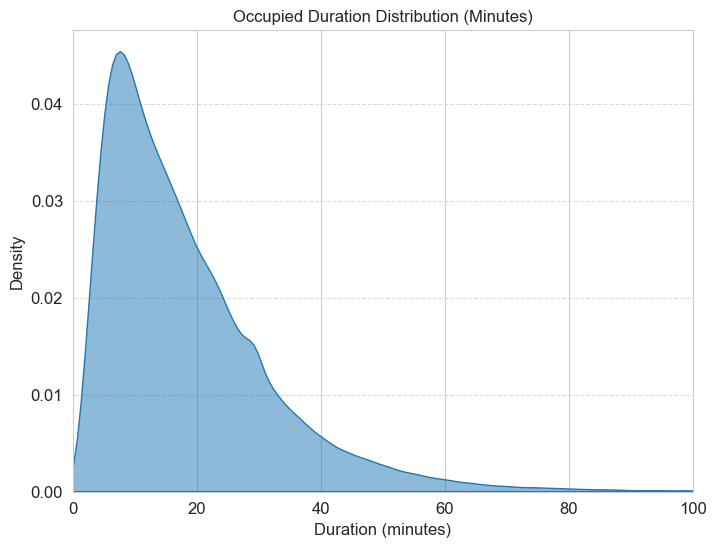

In [12]:
# 绘制 occupied_duration_min 的分布
plot_single_time_distribution(
    df_result_orders,
    "occupied_duration(min)",
    "Occupied Duration Distribution (Minutes)",
    x_min=0,
    x_max=100,
)

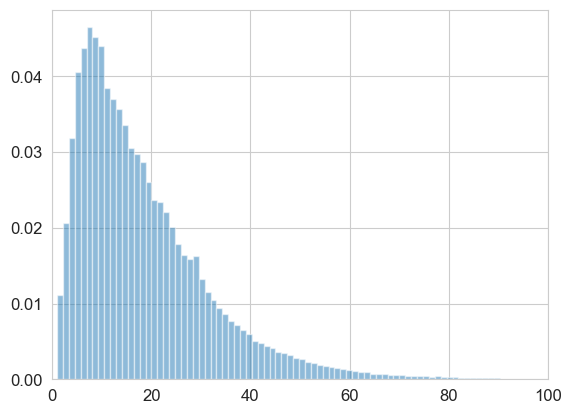

In [13]:
plt.hist(df_result_orders["occupied_duration(min)"], bins=100, density=True, alpha=0.5)
plt.xlim(0, 100)
plt.show()

## 订单的距离分布

In [14]:
def plot_single_distance_distribution(df, column, title, x_min=0, x_max=10):
    """
    绘制单个距离分布图，带 x 轴范围控制

    参数：
    - df: 包含距离数据的 DataFrame
    - column: 待绘制分布的列名
    - title: 图表标题
    - x_min: x 轴最小值
    - x_max: x 轴最大值
    """
    # 设置图形大小和风格
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # 绘制分布图，限制 x 轴范围
    sns.kdeplot(df[column], fill=True, alpha=0.5, clip=(x_min, x_max))

    # 设置 x 轴范围
    plt.xlim(x_min, x_max)

    # 添加标题和标签
    plt.title(title, fontsize=16)
    plt.xlabel("Distance (km)", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
# 绘制 idle_distance 的分布，x 轴范围 0 ~ 10 公里
plot_single_distance_distribution(
    df_result_orders,
    "idle_distance",
    "Idle Distance Distribution (km)",
    x_min=0,
    x_max=10,
)

In [ ]:
# 绘制 pickup_distance 的分布，x 轴范围 0 ~ 5 公里
plot_single_distance_distribution(
    df_result_orders,
    "pickup_distance",
    "Pickup Distance Distribution (km)",
    x_min=0,
    x_max=3,
)

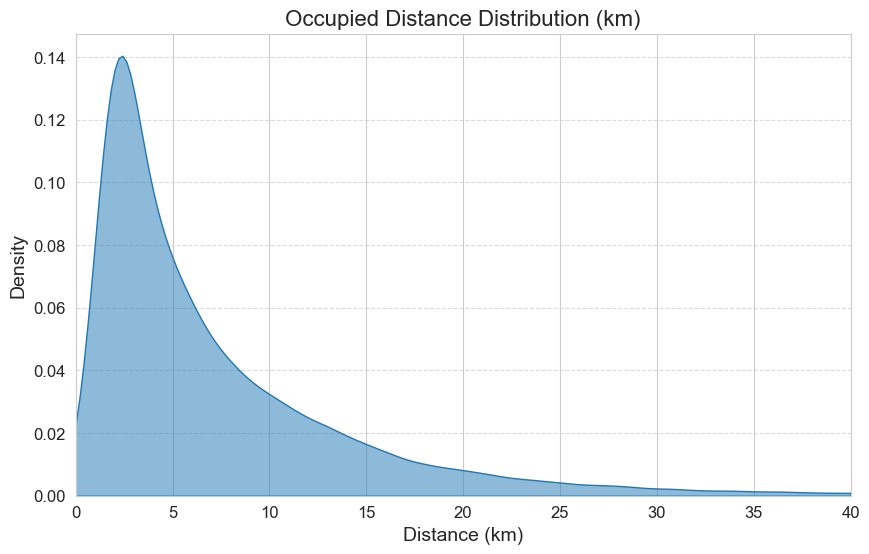

In [15]:
# 绘制 occupied_distance 的分布，x 轴范围 0 ~ 20 公里
plot_single_distance_distribution(
    df_result_orders,
    "occupied_distance",
    "Occupied Distance Distribution (km)",
    x_min=0,
    x_max=40,
)

## 订单的收入分布

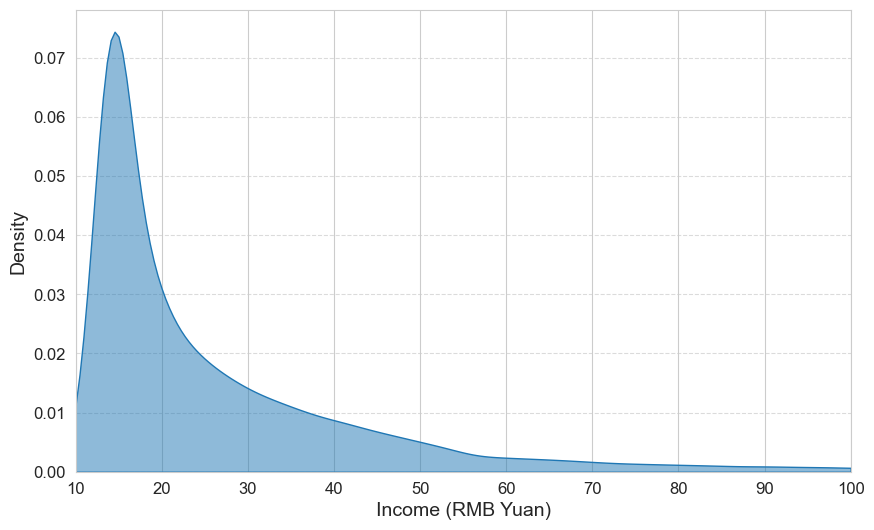

In [16]:
x_min = 10
x_max = 100

# 设置图形大小和风格
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# 绘制分布图，限制 x 轴范围
sns.kdeplot(df_result_orders["order_income"], fill=True, alpha=0.5, clip=(x_min, x_max))

# 设置 x 轴范围
plt.xlim(x_min, x_max)

# 添加标题和标签
plt.xlabel("Income (yuan yuan)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 订单 - 时间维度

## 订单收入在时间上的分布

In [18]:
def plot_hourly_error_bars(df, column):
    """
    绘制每小时的订单收入分布的误差条

    参数：
    - df: 包含订单数据的 DataFrame，需包含特定 column 和 'occupied_start_time' 列
    """
    # 转换时间为小时
    df["occupied_start_hour"] = df["occupied_start_time"] // 3600  # 将秒转换为小时

    # 聚合数据：按小时计算平均值和误差
    hourly_data = (
        df.groupby("occupied_start_hour")[column]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    hourly_data["stderr"] = hourly_data["std"] / (hourly_data["count"] ** 0.5)  # 计算标准误差

    # 绘制误差条图
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    plt.errorbar(
        hourly_data["occupied_start_hour"],
        hourly_data["mean"],
        yerr=hourly_data["stderr"],
        fmt="o",
        capsize=5,
        capthick=2,
        color="blue",
        ecolor="grey",
        label="Order Income with Error Bar",
    )

    # 图表美化
    plt.title("Average Order Income by Hour with Error Bars", fontsize=14)
    plt.xlabel("Occupied Start Time (Hour)", fontsize=12)
    plt.ylabel("Average Order Income (yuan)", fontsize=12)
    plt.xticks(range(0, 24))  # 显示 0-23 小时
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

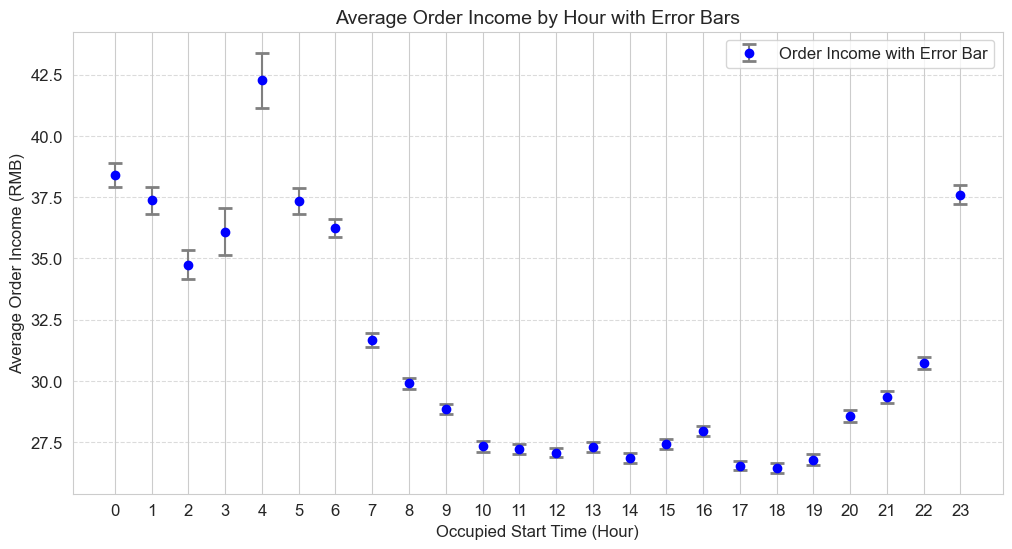

In [19]:
# 示例调用
plot_hourly_error_bars(df_result_orders, "order_income")

## 订单数量在时间上的分布

In [22]:
def plot_hourly_order_count(df):
    """
    绘制每小时的订单比例分布的误差条

    参数：
    - df: 包含订单数据的 DataFrame，需包含 'occupied_start_time' 列
    """
    # 转换时间为小时
    df["occupied_start_hour"] = df["occupied_start_time"] // 3600  # 将秒转换为小时

    # 聚合数据：按小时计算订单数量并计算比例
    hourly_data = (
        df.groupby("occupied_start_hour").size().reset_index(name="order_count")
    )
    total_orders = hourly_data["order_count"].sum()  # 总订单数
    hourly_data["percentage"] = hourly_data["order_count"] / total_orders  # 计算每小时比例

    # 计算标准误差（假设多个样本分布类似）
    hourly_data["std"] = hourly_data["percentage"].std()
    hourly_data["stderr"] = hourly_data["std"] / (
        hourly_data["order_count"].count() ** 0.5
    )

    # 绘制误差条图
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    plt.errorbar(
        hourly_data["occupied_start_hour"],
        hourly_data["percentage"],
        yerr=hourly_data["stderr"],
        fmt="o",
        capsize=5,
        capthick=2,
        color="red",
        ecolor="grey",
        label="Order Percentage with Error Bar",
    )

    # 图表美化
    plt.title("Order count by Hour with Error Bars", fontsize=14)
    plt.xlabel("Occupied Start Time (Hour)", fontsize=12)
    plt.ylabel("Order Percentage", fontsize=12)
    plt.xticks(range(0, 24))  # 显示 0-23 小时
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

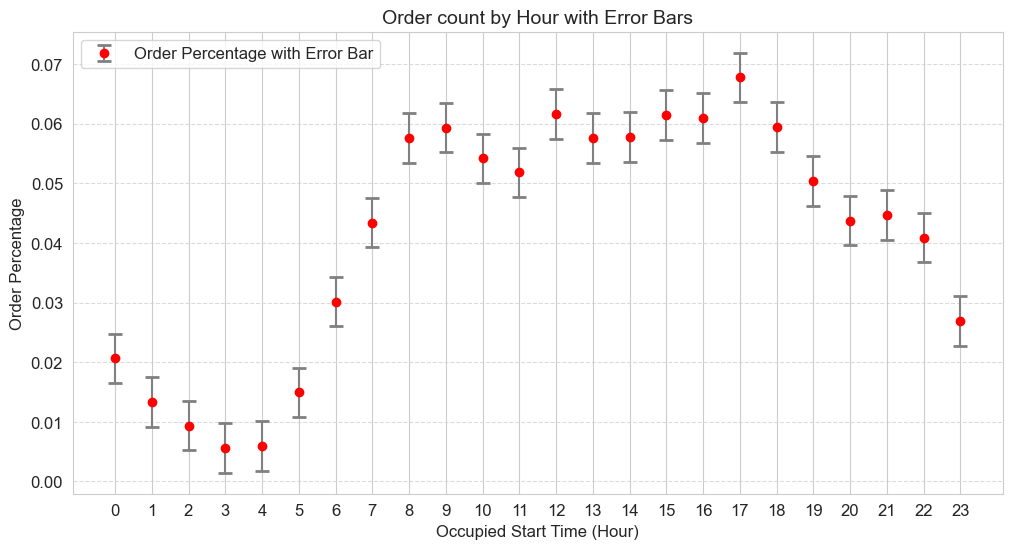

In [23]:
# 示例调用
plot_hourly_order_count(df_result_orders)

## 订单数量和收入在时间上的分布

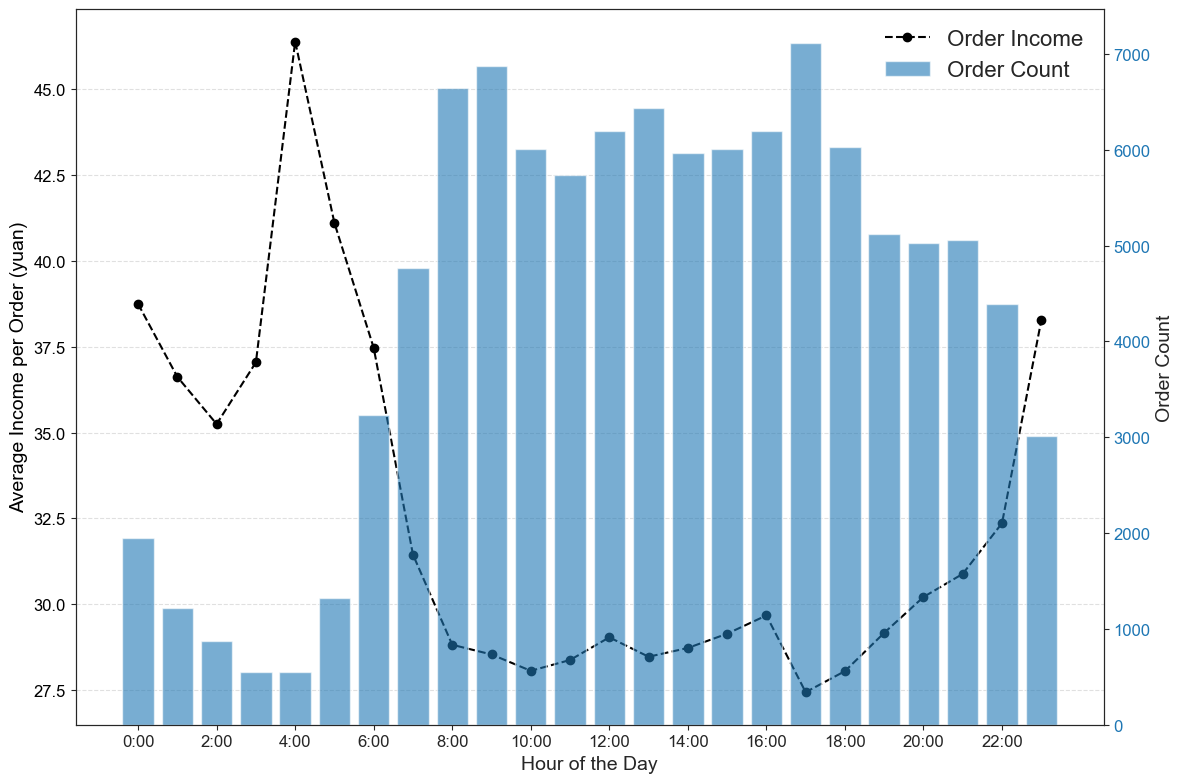

In [23]:
# 绘制每小时收入和订单数量（左侧为收入曲线，右侧为订单数量直方图）
# 将秒转换为小时
df_result_orders["occupied_start_hour"] = (
    df_result_orders["occupied_start_time"] // 3600
)

# 1. 计算每小时收入数据
income_data = (
    df_result_orders.groupby("occupied_start_hour")["order_income"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# 2. 计算每小时订单数量数据
count_data = (
    df_result_orders.groupby("occupied_start_hour")
    .size()
    .reset_index(name="order_count")
)
count_data["order_count"] = count_data["order_count"] / len(
    df_result_orders["date"].unique()
)

# 绘制每小时收入和订单数量
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.set_style("ticks")  # 使用简洁样式

# 绘制收入曲线在左 Y 轴
ax1.plot(
    income_data["occupied_start_hour"],
    income_data["mean"],
    marker="o",
    linestyle="--",
    color="black",
    label="Order Income",
)
ax1.set_xlabel("Hour of the Day", fontsize=14)  # 修改 X 轴名称
ax1.set_ylabel(
    "Average Income per Order (yuan)", fontsize=14, color="black"
)  # 修改左 Y 轴名称
ax1.tick_params(axis="y", labelcolor="black", labelsize=12)
ax1.tick_params(axis="x", labelsize=12)

# 调整 X 轴刻度
ax1.set_xticks(range(0, 24, 2))  # 每 2 小时显示一个刻度
ax1.set_xticklabels([f"{i}:00" for i in range(0, 24, 2)], fontsize=12)

# 绘制订单数量直方图在右 Y 轴
ax2 = ax1.twinx()
ax2.bar(
    count_data["occupied_start_hour"],
    count_data["order_count"],
    alpha=0.6,
    label="Order Count",
    width=0.8,
    color="C0",  # 修改颜色以区分
)
ax2.set_ylabel("Order Count", fontsize=14)
ax2.tick_params(axis="y", labelcolor="C0", labelsize=12)

# 图表美化
ax1.grid(axis="y", linestyle="--", alpha=0.6)  # 显示左侧网格线
fig.tight_layout()

# 图例优化，放大字体并调整位置
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax2.legend(
    lines_labels[0] + bars_labels[0],
    lines_labels[1] + bars_labels[1],
    loc="upper right",
    fontsize=16,  # 放大字体
    frameon=False,
)

# 保存为高清图片
plt.savefig("1.png", dpi=300, bbox_inches="tight")
plt.show()

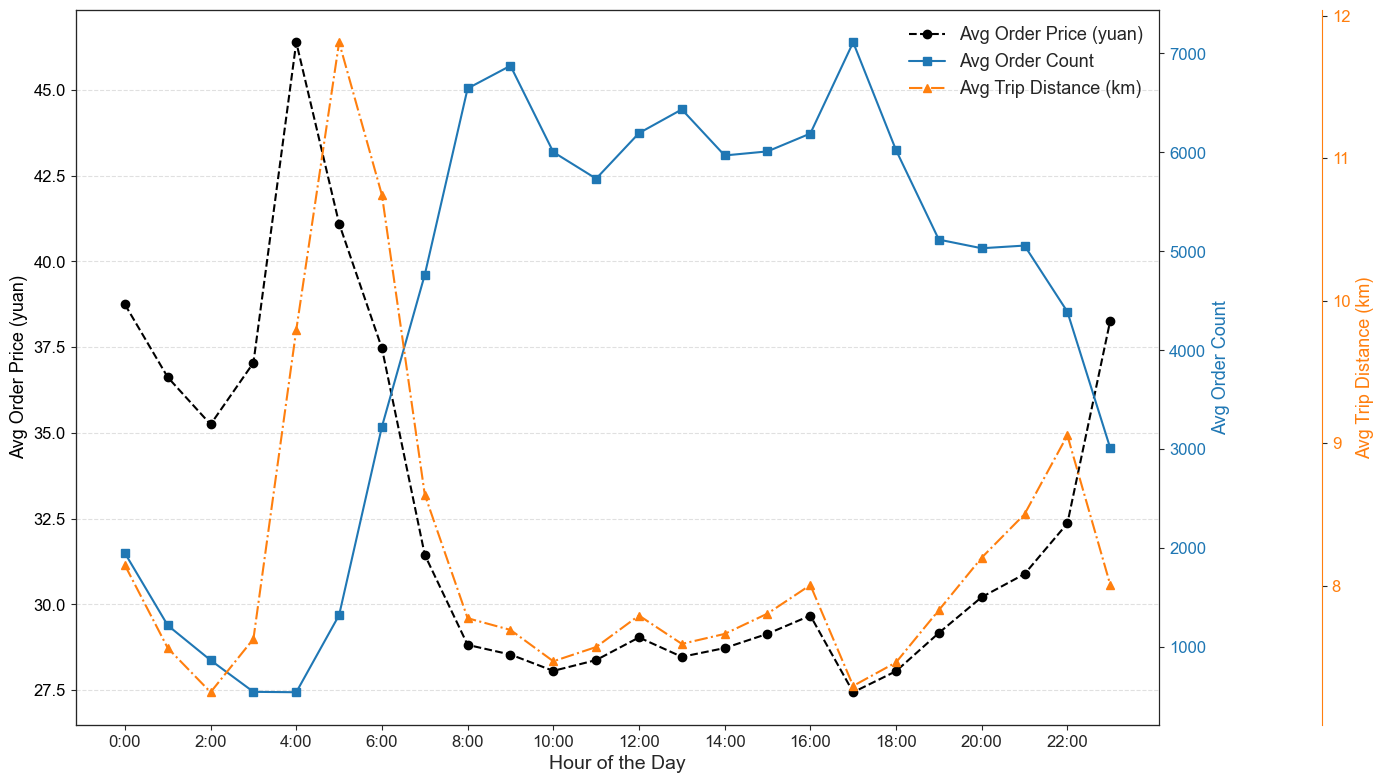

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 数据预处理
df_result_orders["occupied_start_hour"] = (
    df_result_orders["occupied_start_time"] // 3600
)

# 每小时平均订单收入
income_data = (
    df_result_orders.groupby("occupied_start_hour")["order_income"]
    .mean()
    .reset_index(name="avg_order_income")
)

# 每小时平均订单数量
count_data = (
    df_result_orders.groupby("occupied_start_hour")
    .size()
    .reset_index(name="order_count")
)
count_data["avg_order_count"] = count_data["order_count"] / len(
    df_result_orders["date"].unique()
)

# 每小时平均行程长度
distance_data = (
    df_result_orders.groupby("occupied_start_hour")["occupied_distance"]
    .mean()
    .reset_index(name="avg_occupied_distance")
)

# 合并数据
plot_data = income_data.merge(
    count_data[["occupied_start_hour", "avg_order_count"]], on="occupied_start_hour"
)
plot_data = plot_data.merge(distance_data, on="occupied_start_hour")

# 开始绘图
fig, ax1 = plt.subplots(figsize=(14, 8))
sns.set_style("ticks")

# ---- 1st Y axis: 订单收入 ----
(p1,) = ax1.plot(
    plot_data["occupied_start_hour"],
    plot_data["avg_order_income"],
    marker="o",
    linestyle="--",
    color="black",
    label="Avg Order Price (yuan)",
)
ax1.set_ylabel("Avg Order Price (yuan)", fontsize=13, color="black")
ax1.tick_params(axis="y", labelcolor="black", labelsize=12)

# ---- 2nd Y axis: 订单数量 ----
ax2 = ax1.twinx()
(p2,) = ax2.plot(
    plot_data["occupied_start_hour"],
    plot_data["avg_order_count"],
    marker="s",
    linestyle="-",
    color="C0",
    label="Avg Order Count",
)
ax2.set_ylabel("Avg Order Count", fontsize=13, color="C0")
ax2.tick_params(axis="y", labelcolor="C0", labelsize=12)

# ---- 3rd Y axis: 行程长度 ----
ax3 = ax1.twinx()
# 右移第三个 Y 轴，避免重合
ax3.spines["right"].set_position(("axes", 1.15))  # 右移15%
(p3,) = ax3.plot(
    plot_data["occupied_start_hour"],
    plot_data["avg_occupied_distance"],
    marker="^",
    linestyle="-.",
    color="C1",
    label="Avg Trip Distance (km)",
)
ax3.set_ylabel("Avg Trip Distance (km)", fontsize=13, color="C1")
ax3.tick_params(axis="y", labelcolor="C1", labelsize=12)

# 同时设置第三个 Y 轴的边框颜色
ax3.spines["right"].set_edgecolor("C1")

# ---- X 轴设置 ----
ax1.set_xlabel("Hour of the Day", fontsize=14)
ax1.set_xticks(range(0, 24, 2))
ax1.set_xticklabels([f"{i}:00" for i in range(0, 24, 2)], fontsize=12)
ax1.grid(axis="y", linestyle="--", alpha=0.6)

# ---- 图例整合 ----
lines = [p1, p2, p3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right", fontsize=13, frameon=False)

# plt.title("Hourly Trends: Price, Order Count, Trip Distance", fontsize=16)
plt.tight_layout()
plt.savefig("hourly_trends.png", dpi=300, bbox_inches="tight")
plt.show()

# 订单 - 地理分布（热力图）

In [24]:
# 提取上车点经纬度
pickup_locations = df_result_orders["occupied_start_location"].dropna()

# 转换上车点数据为 GeoDataFrame
pickup_points = [
    Point(location[1], location[0])  # 注意: 经度(lon)在前，纬度(lat)在后
    for location in pickup_locations
]
pickups_gdf = gpd.GeoDataFrame({"geometry": pickup_points}, crs="EPSG:4326")

# 统计订单密度（经纬度频率）
pickup_counts = pickups_gdf.groupby("geometry").size().reset_index(name="order_density")
pickup_counts_gdf = gpd.GeoDataFrame(
    pickup_counts, geometry="geometry", crs="EPSG:4326"
)

# 上海市中心经纬度
center = [31.2304, 121.4737]  # 上海市中心

# 创建基础地图
m = Map(location=center, zoom_start=12, tiles="cartodbpositron")

# 准备热力图数据（纬度、经度、权重）
heatmap_data = [
    (point.y, point.x, density)
    for point, density in zip(
        pickup_counts_gdf.geometry, pickup_counts_gdf["order_density"]
    )
]

# 创建热力图
HeatMap(heatmap_data, radius=20, blur=20, max_zoom=1, min_opacity=0.2).add_to(m)

# 创建颜色条
colormap = cm.LinearColormap(
    colors=["blue", "green", "yellow", "red"],  # 热力图颜色梯度
    vmin=min(pickup_counts_gdf["order_density"]),  # 最小订单密度
    vmax=max(pickup_counts_gdf["order_density"]),  # 最大订单密度
    caption="Order Density (Counts)",  # 颜色条标题
)

# 将颜色条添加到地图
colormap.add_to(m)

# 保存热力图为 HTML 文件
m.save("order_density_heatmap.html")

# 订单 - 网络维度

## 分割网格

**出租车从订单起点 idle_start，到订单终点 occupied_end**

In [12]:
# 修改网格计算函数以更新字典
def calculate_grid(lat, lon):
    # 定义地理网格参数
    origin_lat, origin_lon = 31.2304, 121.4737  # 原点坐标
    lat_step, lon_step = 0.009, 0.011  # 1km 对应纬度和经度的步长

    # 计算网格编号
    i = int((lat - origin_lat) / lat_step)
    j = int((lon - origin_lon) / lon_step)

    # 计算中心点经纬度
    center_lat = origin_lat + (i + 1) * lat_step
    center_lon = origin_lon + (j + 1) * lon_step

    grid_name = f"Grid_{i}_{j}"
    # 更新字典
    if grid_name not in grid_mapping:
        grid_mapping[grid_name] = (center_lat, center_lon)

    return grid_name

In [13]:
# 创建空字典用于保存 grid_name 到 grid_center 的映射
grid_mapping = {}

# 订单起点
df_result_orders["start_grid_name"] = df_result_orders["idle_start_location"].apply(
    lambda loc: calculate_grid(loc[0], loc[1])
)
# 订单终点
df_result_orders["end_grid_name"] = df_result_orders["occupied_end_location"].apply(
    lambda loc: calculate_grid(loc[0], loc[1])
)

## 构建订单网络

In [14]:
def generate_grid_network():
    # 初始化有向图
    G = nx.DiGraph()

    # 计算节点和边的属性
    for _, row in tqdm(df_result_orders.iterrows(), total=df_result_orders.shape[0]):
        start = row["start_grid_name"]
        end = row["end_grid_name"]
        income = row["order_income"]
        distance = row["idle_distance"] + row["pickup_distance"]
        duration1 = row["idle_duration(min)"] + row["pickup_duration(min)"]  # 空载时间
        duration2 = duration1 + row["occupied_duration(min)"]  # 订单总体时间

        # 更新节点属性
        if start not in G.nodes:
            G.add_node(
                start,
                total_income=0,
                total_distance=0,
                total_duration1=0,
                total_duration2=0,
                orders_count=0,
                start=False,
                end=False,
            )
        if end not in G.nodes:
            G.add_node(
                end,
                total_income=0,
                total_distance=0,
                total_duration1=0,
                total_duration2=0,
                orders_count=0,
                start=False,
                end=False,
            )
        G.nodes[start]["orders_count"] += 1
        G.nodes[start]["total_income"] += income
        G.nodes[start]["total_distance"] += distance
        G.nodes[start]["total_duration1"] += duration1
        G.nodes[start]["total_duration2"] += duration2
        G.nodes[start]["start"] = True
        G.nodes[end]["end"] = True

        # 更新边属性
        if not G.has_edge(start, end):
            G.add_edge(
                start,
                end,
                orders_count=0,
                total_income=0,
                total_distance=0,
                total_duration1=0,
                total_duration2=0,
            )
        G[start][end]["orders_count"] += 1
        G[start][end]["total_income"] += income
        G[start][end]["total_distance"] += distance
        G[start][end]["total_duration1"] += duration1
        G[start][end]["total_duration2"] += duration2

    # 计算节点属性平均值
    for node, data in G.nodes(data=True):
        if data["orders_count"] > 0:
            data["average_income"] = data["total_income"] / data["orders_count"]
            data["average_distance"] = data["total_distance"] / data["orders_count"]
            data["average_idle_duration"] = (
                data["total_duration1"] / data["orders_count"]
            )
            data["average_total_duration"] = (
                data["total_duration2"] / data["orders_count"]
            )

    # 计算连边属性平均值
    for start, end, data in G.edges(data=True):
        if data["orders_count"] > 0:
            data["average_income"] = data["total_income"] / data["orders_count"]
            data["average_distance"] = data["total_distance"] / data["orders_count"]
            data["average_idle_duration"] = (
                data["total_duration1"] / data["orders_count"]
            )
            data["average_total_duration"] = (
                data["total_duration2"] / data["orders_count"]
            )

    return G


G = generate_grid_network()

100%|██████████| 1062666/1062666 [01:12<00:00, 14669.82it/s]


In [15]:
# 保存 graph，在 gephi 中打开
nx.write_graphml(G, "taxi.graphml")

df_grid = pd.DataFrame(
    [{"Id": k, "lat": v[0], "lng": v[1]} for k, v in grid_mapping.items()]
)
df_grid.to_csv("grid.csv", index=False)

**订单的起点集合和终点集合不同**

In [16]:
# 节点集合
common_nodes = set()  # 同时作为起点和终点
start_only_nodes = set()  # 只作为起点
end_only_nodes = set()  # 只作为终点

for node, attrs in G.nodes(data=True):
    start = attrs.get("start")  # 获取 start 属性
    end = attrs.get("end")  # 获取 end 属性

    # 分类节点
    if start and end:
        common_nodes.add(node)
    elif start:
        start_only_nodes.add(node)
    elif end:
        end_only_nodes.add(node)

# 输出节点集合
print("同时作为起点和终点:", len(common_nodes))
print("只作为起点:", len(start_only_nodes))
print("只作为终点:", len(end_only_nodes))

同时作为起点和终点: 4846
只作为起点: 386
只作为终点: 203


In [17]:
# 只保留共同节点
G = G.subgraph(common_nodes)

## 马尔科夫状态转移矩阵

In [18]:
def extract_transition_matrix(G, common_nodes):
    """
    提取马尔科夫转移矩阵
    :param G: 有向图 (nx.DiGraph)
    :return: 转移矩阵 (numpy.array)
    """
    n = len(G)
    transition_matrix = np.zeros((n, n))  # 初始化转移矩阵

    # 创建节点到索引的映射
    node_to_index = {node: i for i, node in enumerate(common_nodes)}

    # 填充转移矩阵
    for start, end, data in G.edges(data=True):
        start_idx = node_to_index[start]
        end_idx = node_to_index[end]
        transition_matrix[start_idx, end_idx] = data.get("orders_count", 0)

    # 按行归一化（确保每行的总和为 1）
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = np.divide(
        transition_matrix,
        row_sums[:, np.newaxis],
        out=np.zeros_like(transition_matrix),
        where=row_sums[:, np.newaxis] != 0,
    )

    return transition_matrix, node_to_index

In [19]:
P, node_to_index = extract_transition_matrix(G, common_nodes)

## 多个订单的期望收入和成本

In [20]:
# 每个节点的收入和成本平均值
Income = np.array([G.nodes[node].get("average_income", 0) for node in node_to_index])
Distance = np.array(
    [G.nodes[node].get("average_distance", 0) for node in node_to_index]
)
Duration_total = np.array(
    [G.nodes[node].get("average_total_duration", 0) for node in node_to_index]
)
Duration_idle = np.array(
    [G.nodes[node].get("average_idle_duration", 0) for node in node_to_index]
)

In [21]:
hour = 8
T = hour * 60
df_result = []

for node in tqdm(node_to_index):
    income_list = []
    distance_list = []
    duration_idle_list = []
    duration_total_list = []
    index = node_to_index[node]
    x_status = True  # 判断 x 状态

    # 初始状态
    x = np.zeros(len(G))
    x[index] = 1

    while 1:
        # 消耗时间
        duration_total = np.dot(x, Duration_total)

        # 判断状态
        if duration_total == 0:
            x_status = False  # x 状态进入死胡同
            break

        if sum(duration_total_list) + duration_total > T:
            break

        # 本轮期望收入和成本
        income_list.append(np.dot(x, Income))
        distance_list.append(np.dot(x, Distance))
        duration_idle_list.append(np.dot(x, Duration_idle))
        duration_total_list.append(duration_total)

        # 更新状态
        x = np.dot(x, P)

    income = sum(income_list)
    distance = sum(distance_list)
    duration_idle = sum(duration_idle_list)
    duration_total = sum(duration_total_list)

    # 保存结果
    df_result.append(
        {
            "grid_name": node,
            "index": index,
            "income": income,
            "distance": distance,
            "duration_idle": duration_idle,
            "duration_total": duration_total,
            "round": len(income_list),
            "route_status": x_status,
        }
    )

df_result = pd.DataFrame(df_result)

100%|██████████| 4846/4846 [05:55<00:00, 13.64it/s]


## 计算 k 核

In [22]:
def calculate_kcore_and_degree_undirected(G):
    """
    将有向图转换为无向图，并计算每个节点的 k-core 和 degree（度数）值。

    参数:
        G: 有向加权图 (DiGraph)

    返回:
        k_core_dict: 每个节点的 k-core 值，字典形式 {节点: k-core 值}
        degree_dict: 每个节点的无向 degree 值，字典形式 {节点: degree 值}
    """
    # 移除自循环
    G_no_selfloops = G.copy()
    G_no_selfloops.remove_edges_from(nx.selfloop_edges(G_no_selfloops))

    # 转换为无向图
    undirected_graph = G_no_selfloops.to_undirected()

    # 计算 k-core 值
    k_core_dict = nx.core_number(undirected_graph)

    # 计算无向图的 degree（默认是边数量，不考虑权重）
    degree_dict = dict(undirected_graph.degree())

    return k_core_dict, degree_dict

In [23]:
kcore_dict, degree_dict = calculate_kcore_and_degree_undirected(G)

# 映射到 df_result
df_result["kcore"] = df_result["grid_name"].map(kcore_dict)
df_result["degree"] = df_result["grid_name"].map(degree_dict)

## 相关性曲线

In [41]:
df_plot = df_result.copy()
df_plot = df_plot[
    (df_result["route_status"])
    & (df_result["round"] <= 15)
    & (df_result["duration_idle"] > 200)
    & (df_result["income"] < 480)
    & (df_result["distance"] < 170)
]

df_plot["income"] = df_plot["income"] / hour
df_plot["distance"] = df_plot["distance"] / hour
df_plot["duration_idle"] = df_plot["duration_idle"] / T

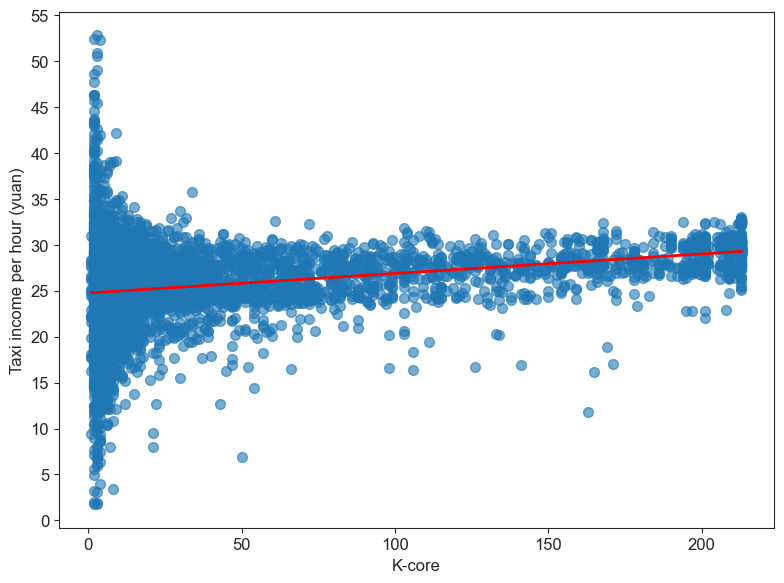

In [42]:
# 绘制散点图和拟合线
plt.figure(figsize=(8, 6))
sns.regplot(
    x="kcore",
    y="income",
    data=df_plot,
    ci=None,
    line_kws={"color": "red", "linewidth": 2},  # 更粗的拟合线
    scatter_kws={"s": 50, "alpha": 0.6},  # 优化散点样式
)

# 图形标题和标签
plt.xlabel("K-core", fontsize=12)
plt.ylabel("Taxi income per hour (yuan)", fontsize=12)

# 设置纵坐标刻度
plt.yticks(np.arange(0, 60, 5), fontsize=12)  # 0.05 的间隔

# 自动调整布局并显示图形
plt.tight_layout()
plt.savefig("3.png", dpi=300)
plt.show()

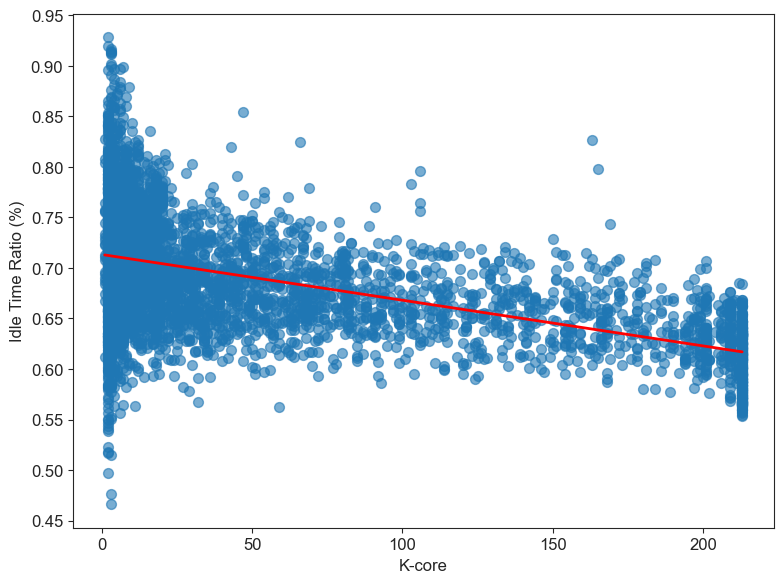

In [45]:
# 绘制散点图和拟合线
plt.figure(figsize=(8, 6))
sns.regplot(
    x="kcore",
    y="duration_idle",
    data=df_plot,
    ci=None,
    line_kws={"color": "red", "linewidth": 2},  # 更粗的拟合线
    scatter_kws={"s": 50, "alpha": 0.6},  # 优化散点样式
)

# 图形标题和标签
# plt.title("Scatter Plot with Fitted Line", fontsize=14)
plt.xlabel("K-core", fontsize=12)
plt.ylabel("Idle Time Ratio (%)", fontsize=12)

# 设置纵坐标刻度
plt.yticks(np.arange(0.45, 1.0, 0.05), fontsize=12)  # 0.05 的间隔

# 优化刻度字体大小
plt.xticks(fontsize=12)

# 自动调整布局并显示图形
plt.tight_layout()
plt.savefig("4.png", dpi=300)
plt.show()

## 热力图

**期望收入**

In [51]:
df_result["location"] = df_result["grid_name"].map(grid_mapping)
incomes = df_result["average_income"]

# 转换上车点数据为 GeoDataFrame
pickup_points = [
    Point(location[1], location[0])  # 注意: 经度(lon)在前，纬度(lat)在后
    for location in df_result["location"]
]
pickups_gdf = gpd.GeoDataFrame(
    {"order_income": incomes, "geometry": pickup_points}, crs="EPSG:4326"
)

In [52]:
# 构建热力图
center = [31.2304, 121.4737]  # 上海市中心的经纬度
# CartoDB positron, OpenStreetMap, cartodbpositron
m = Map(location=center, zoom_start=12, tiles="cartodbpositron")

# 准备热力图数据（纬度、经度、权重）
heatmap_data = [
    (point.y, point.x, income)
    for point, income in zip(pickups_gdf.geometry, pickups_gdf["order_income"])
]
HeatMap(heatmap_data, radius=5, blur=5, max_zoom=1).add_to(m)

# 保存热力图为 HTML 文件
m.save("N_order_income_heatmap.html")

**期望成本（距离）**

In [53]:
df_result["location"] = df_result["grid_name"].map(grid_mapping)
average_distance = df_result["average_distance"]

# 转换上车点数据为 GeoDataFrame
pickup_points = [
    Point(location[1], location[0])  # 注意: 经度(lon)在前，纬度(lat)在后
    for location in df_result["location"]
]
pickups_gdf = gpd.GeoDataFrame(
    {"average_distance": average_distance, "geometry": pickup_points}, crs="EPSG:4326"
)

In [54]:
# 构建热力图
center = [31.2304, 121.4737]  # 上海市中心的经纬度
# CartoDB positron, OpenStreetMap, cartodbpositron
m = Map(location=center, zoom_start=12, tiles="cartodbpositron")

# 准备热力图数据（纬度、经度、权重）
heatmap_data = [
    (point.y, point.x, distance)
    for point, distance in zip(pickups_gdf.geometry, pickups_gdf["average_distance"])
]
HeatMap(heatmap_data, radius=5, blur=5, max_zoom=1).add_to(m)

# 保存热力图为 HTML 文件
m.save("N_order_distance_heatmap.html")

**期望成本（时间）**

In [55]:
df_result["location"] = df_result["grid_name"].map(grid_mapping)
average_duration = df_result["average_duration"]

# 转换上车点数据为 GeoDataFrame
pickup_points = [
    Point(location[1], location[0])  # 注意: 经度(lon)在前，纬度(lat)在后
    for location in df_result["location"]
]
pickups_gdf = gpd.GeoDataFrame(
    {"average_duration": average_duration, "geometry": pickup_points}, crs="EPSG:4326"
)

In [56]:
# 构建热力图
center = [31.2304, 121.4737]  # 上海市中心的经纬度
# CartoDB positron, OpenStreetMap, cartodbpositron
m = Map(location=center, zoom_start=12, tiles="cartodbpositron")

# 准备热力图数据（纬度、经度、权重）
heatmap_data = [
    (point.y, point.x, duration)
    for point, duration in zip(pickups_gdf.geometry, pickups_gdf["average_duration"])
]
HeatMap(heatmap_data, radius=5, blur=5, max_zoom=1).add_to(m)

# 保存热力图为 HTML 文件
m.save("N_order_duration_heatmap.html")

**K-core**

In [24]:
df_result["location"] = df_result["grid_name"].map(grid_mapping)
kcore = df_result["kcore"]

# 转换上车点数据为 GeoDataFrame
pickup_points = [
    Point(location[1], location[0])  # 注意: 经度(lon)在前，纬度(lat)在后
    for location in df_result["location"]
]
pickups_gdf = gpd.GeoDataFrame(
    {"kcore": kcore, "geometry": pickup_points}, crs="EPSG:4326"
)

In [31]:
# 1. 基础地图
center = [31.2304, 121.4737]  # 上海市中心
m = Map(location=center, zoom_start=12, tiles="cartodbpositron")

# 2. 热力图数据准备
heatmap_data = [
    (point.y, point.x, kcore)
    for point, kcore in zip(pickups_gdf.geometry, pickups_gdf["kcore"])
]

# 3. 添加热力图
HeatMap(heatmap_data, radius=5, blur=2.5, max_zoom=1).add_to(m)

# 4. 创建颜色条
colormap = cm.LinearColormap(
    colors=["blue", "green", "yellow", "red"],
    vmin=pickups_gdf["kcore"].min(),
    vmax=pickups_gdf["kcore"].max(),
    caption="K-core Value",  # 颜色条标题
)

# 5. 将颜色条添加到地图
colormap.add_to(m)

# 6. 保存地图
m.save("N_order_kcore_heatmap.html")

## degree 和 k-core 对比

In [24]:
df_result[df_result["kcore"] == 213]

,grid_name,index,income,distance,duration_idle,duration_total,round,route_status,kcore,degree
15,Grid_-7_-9,15,246.036433,40.114104,310.534620,469.421521,8,True,213,461
20,Grid_2_-4,20,234.012554,35.816937,276.265767,431.480879,8,True,213,699
37,Grid_-1_2,37,262.595007,40.309719,303.985317,478.529105,9,True,213,576
42,Grid_1_-10,42,240.811165,38.996285,304.104543,461.492833,8,True,213,436
60,Grid_-2_-9,60,238.244674,37.640107,289.802354,446.956284,8,True,213,565
...,...,...,...,...,...,...,...,...,...,...
4811,Grid_-3_-5,4811,235.635915,35.734769,273.437310,430.543320,8,True,213,662
4819,Grid_-3_2,4819,236.771563,37.276649,278.089871,433.589453,8,True,213,527
4826,Grid_11_-3,4826,207.853689,34.460678,292.364556,428.046244,7,True,213,489
4834,Grid_-3_-16,4834,223.304724,39.373834,309.582399,452.145677,7,True,213,555


In [58]:
df_result.describe()

,index,income,distance,duration_idle,duration_total,round,kcore,degree
count,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000,4846.000000
mean,2422.500000,209.618316,47.949214,328.198373,446.481869,6.634544,55.311391,99.678910
std,1399.064032,122.267931,12.291297,38.014312,37.289304,8.368127,70.578399,172.770552
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1211.250000,189.505885,40.165630,310.396957,433.816013,6.000000,6.000000,6.000000
50%,2422.500000,211.421720,44.843364,328.044658,448.455858,7.000000,18.000000,22.000000
75%,3633.750000,229.860201,54.527315,347.825141,464.114053,7.000000,81.000000,107.000000
max,4845.000000,5040.000000,147.681569,445.650000,480.000000,360.000000,213.000000,2266.000000


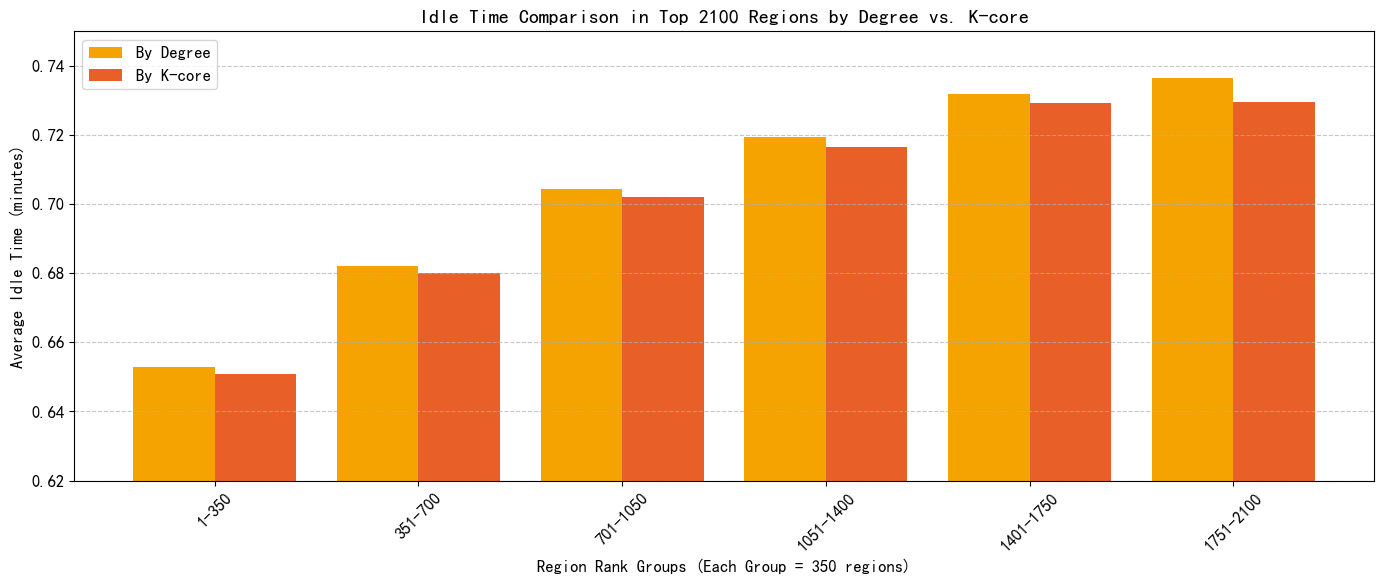

In [36]:
# 计算空载率
df_result["idle"] = df_result["duration_idle"] / df_result["duration_total"]

# 获取前 500 个区域数据
group_size = 350
N = 6 * group_size
num_groups = int(N / group_size)

top500_degree = df_result.sort_values("degree", ascending=False).head(N)
top500_kcore = df_result.sort_values("kcore", ascending=False).head(N)

# 分组计算平均空载率
degree_bins_500 = [
    top500_degree.iloc[i : i + group_size]["idle"].mean()
    for i in range(0, N, group_size)
]
kcore_bins_500 = [
    top500_kcore.iloc[i : i + group_size]["idle"].mean()
    for i in range(0, N, group_size)
]

# 横坐标标签
x_labels_500 = [f"{i*group_size+1}-{(i+1)*group_size}" for i in range(num_groups)]
x_500 = np.arange(num_groups)
bar_width = 0.4

# 绘图
plt.figure(figsize=(14, 6))
plt.bar(
    x_500 - bar_width / 2,
    degree_bins_500,
    width=bar_width,
    label="By Degree",
    color="#F4A300",
)
plt.bar(
    x_500 + bar_width / 2,
    kcore_bins_500,
    width=bar_width,
    label="By K-core",
    color="#E95F28",
)

plt.xlabel(f"Region Rank Groups (Each Group = {group_size} regions)")
plt.ylabel("Average Idle Time (minutes)")
plt.title(f"Idle Time Comparison in Top {N} Regions by Degree vs. K-core")
plt.xticks(ticks=x_500, labels=x_labels_500, rotation=45)
# plt.ylim(290, 335)  # 设置 y 轴范围以便对比更明显
plt.ylim(0.62, 0.75)  # 设置 y 轴范围以便对比更明显
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("degree vs kcore.png")
plt.show()

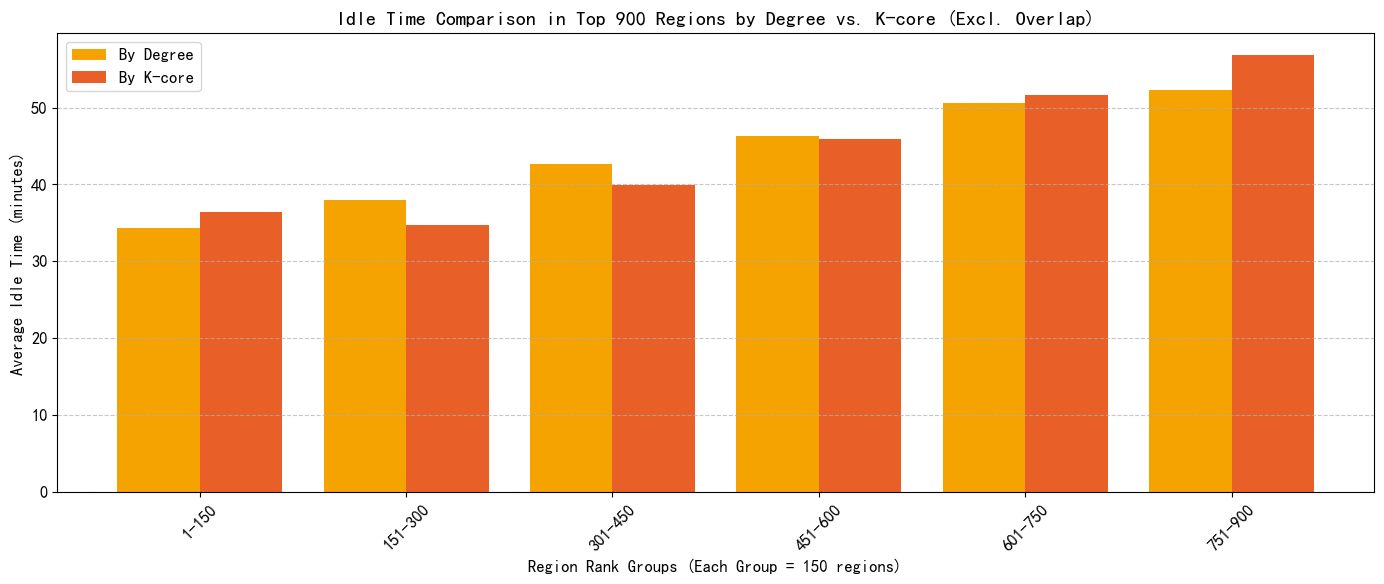

In [55]:
# 计算空载率
df_result["idle"] = df_result["duration_idle"] / df_result["duration_total"]

# 设置参数
group_size = 350
N = 6 * group_size
num_groups = int(N / group_size)

# 按 degree 和 kcore 排序
top500_degree = df_result.sort_values("degree", ascending=False).head(N)
top500_kcore = df_result.sort_values("kcore", ascending=False).head(N)

degree_bins_500 = []
kcore_bins_500 = []

for i in range(0, N, group_size):
    degree_group = top500_degree.iloc[i : i + group_size]
    kcore_group = top500_kcore.iloc[i : i + group_size]

    # 获取当前分组中的 id 集合用于去交集
    degree_ids = set(degree_group.index)
    kcore_ids = set(kcore_group.index)

    # 差集：degree 专属部分和 kcore 专属部分（转换为 list）
    degree_diff_ids = list(degree_ids - kcore_ids)
    kcore_diff_ids = list(kcore_ids - degree_ids)

    # 分别计算空载率平均值
    degree_idle_mean = (
        df_result.loc[degree_diff_ids]["idle"].mean() if degree_diff_ids else np.nan
    )
    kcore_idle_mean = (
        df_result.loc[kcore_diff_ids]["idle"].mean() if kcore_diff_ids else np.nan
    )

    degree_bins_500.append(degree_idle_mean)
    kcore_bins_500.append(kcore_idle_mean)

# 横坐标标签
x_labels_500 = [f"{i*group_size+1}-{(i+1)*group_size}" for i in range(num_groups)]
x_500 = np.arange(num_groups)
bar_width = 0.4

# 绘图
plt.figure(figsize=(14, 6))
plt.bar(
    x_500 - bar_width / 2,
    degree_bins_500,
    width=bar_width,
    label="By Degree",
    color="#F4A300",
)
plt.bar(
    x_500 + bar_width / 2,
    kcore_bins_500,
    width=bar_width,
    label="By K-core",
    color="#E95F28",
)

plt.xlabel(f"Region Rank Groups (Each Group = {group_size} regions)")
plt.ylabel("Average Idle Time (minutes)")
plt.title(
    f"Idle Time Comparison in Top {N} Regions by Degree vs. K-core (Excl. Overlap)"
)
plt.xticks(ticks=x_500, labels=x_labels_500, rotation=45)
# plt.ylim(30, 60)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("degree_vs_kcore_excl_overlap.png")
plt.show()

仅在 Top K-core 中的节点数量: 27
仅在 Top Degree 中的节点数量: 27
仅在 Top K-core 中的节点平均空载时间: 37.1031310950886
仅在 Top Degree 中的节点平均空载时间: 42.28274105023898


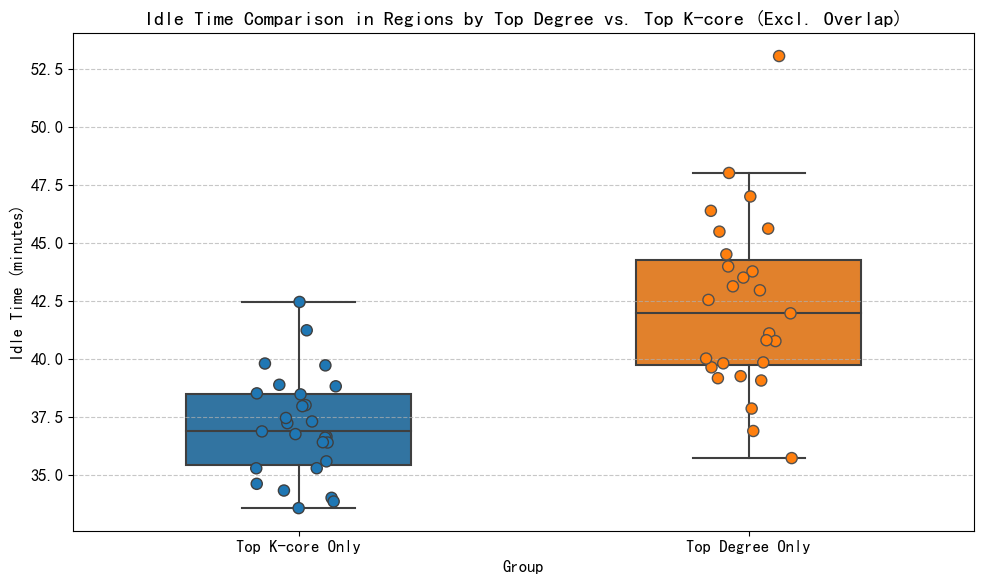

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 假设 df_result 已经包含 "duration_idle", "duration_total", "degree", "kcore" 等字段
# 计算空载率
df_result["idle"] = df_result["duration_idle"] / df_result["round"]

# 分别取 top 325 节点（假设 DataFrame 的 index 为节点标识）
top325_degree = df_result.sort_values("degree", ascending=False).head(325)
top325_kcore = df_result.sort_values("kcore", ascending=False).head(325)

# 将节点转换为集合（假设 index 为唯一节点标识）
degree_set = set(top325_degree.index)
kcore_set = set(top325_kcore.index)

# 找出仅在 Top K-core 中但不在 Top Degree 中的节点
only_kcore_nodes = list(kcore_set - degree_set)
only_kcore = df_result.loc[only_kcore_nodes]

# 找出仅在 Top Degree 中但不在 Top K-core 中的节点
only_degree_nodes = list(degree_set - kcore_set)
only_degree = df_result.loc[only_degree_nodes]

# 输出各组统计信息
print("仅在 Top K-core 中的节点数量:", len(only_kcore))
print("仅在 Top Degree 中的节点数量:", len(only_degree))
print("仅在 Top K-core 中的节点平均空载时间:", only_kcore["idle"].mean())
print("仅在 Top Degree 中的节点平均空载时间:", only_degree["idle"].mean())

# 构造合并后的 DataFrame，并添加 group 标签
df_scatter = pd.concat(
    [
        only_kcore.assign(group="Top K-core Only"),
        only_degree.assign(group="Top Degree Only"),
    ]
)

# 定义各组的自定义颜色
custom_palette = {"Top K-core Only": "#1f77b4", "Top Degree Only": "#ff7f0e"}

plt.figure(figsize=(10, 6))

# 绘制箱线图，使用自定义颜色（注意此处 palette 会让每个箱体上色）
sns.boxplot(
    x="group", y="idle", data=df_scatter, width=0.5, fliersize=0, palette=custom_palette
)

# 叠加散点图，使用相同的自定义颜色，并添加 jitter 避免点重叠
sns.stripplot(
    x="group",
    y="idle",
    data=df_scatter,
    jitter=True,
    size=8,
    edgecolor="gray",
    linewidth=1,
    palette=custom_palette,
)

plt.xlabel("Group")
plt.ylabel("Idle Time (minutes)")
plt.title(
    f"Idle Time Comparison in Regions by Top Degree vs. Top K-core (Excl. Overlap)"
)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("idle_scatter_boxplot_combined_colored.png")
plt.show()